<a href="https://colab.research.google.com/github/JuniorHZ19/CNN-PARA-DETECION-DE-OBJETOS/blob/main/R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

!pip uninstall opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.10

Número de regiones propuestas: 1208


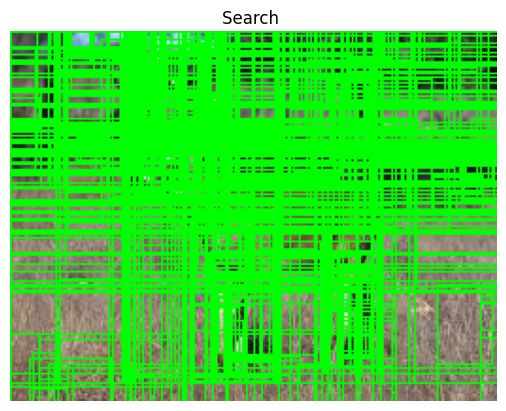

In [ ]:
#Creando funcion para generacion de regioness propuestas:

import cv2
import matplotlib.pyplot as plt

# Cargar la imagen
image = cv2.imread('/content/images (1).jpg')

def get_Region_Proposals(img,max_regiones=2000):
# Crear un objeto de Selective Search
 ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# Configurar la imagen para Selective Search
 ss.setBaseImage(img)

# Modo rápido o calidad

 #ss.switchToSelectiveSearchFast()  # Más rápido pero menos preciso

 ss.switchToSelectiveSearchQuality()  # Más preciso pero más lento

# Ejecutar Selective Search para obtener las regiones propuestas
 rects = ss.process()

 print(f"Número de regiones propuestas: {len(rects)}")

 return rects[:max_regiones]


rectas_propuestas=get_Region_Proposals(image)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Dibujar las regiones propuestas en la imagen
for (x, y, w, h) in rectas_propuestas:  # Limitar a las primeras 100 regiones para visualizar
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 1)
# Mostrar la imagen con Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

(224, 224, 3)


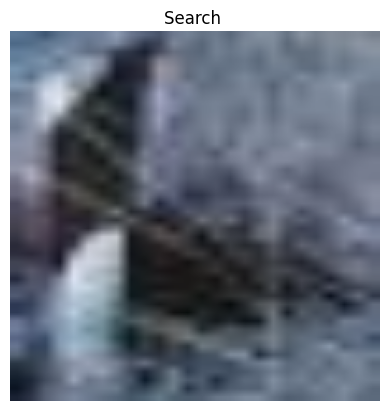

In [ ]:
#Funcion redimension dee regiones para entrada al cnn:

def extract_region(image,rect,size=(224,224)):
  x=rect[0]
  y=rect[1]
  w=rect[2]
  h=rect[3]

  region=image[y:y+h, x:x+w] #crop imagen segun recta

  img_region=cv2.resize(region, size) #redimensionar para entrada a vgg16 imanges 224x224

  return img_region

img=extract_region(image,rectas_propuestas[10])

print(img.shape)

plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

In [ ]:
#Crear extractor de  features con VGG16:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
import numpy as np


vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()

# Definir las transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar según ImageNet
])

def extract_features_from_regions(image):
    all_features = []

    regions= get_Region_Proposals(image)

    for region in regions:

        region_extracted=extract_region(image,region)

        # Convertir la región redimensionada a tensor
        input_tensor = transform(region_extracted).to(device)
        input_tensor = input_tensor.unsqueeze(0)  # Añadir batch dimension
        input_tensor = Variable(input_tensor)

        # Extraer características usando VGG16
        with torch.no_grad():
            features = vgg16.features(input_tensor)  # Extraer las características

        all_features.append(features.squeeze().cpu().numpy())  # Almacenar las características

    return np.array(all_features)

# Extraer características de las regiones generadas

image = cv2.imread('/content/images (1).jpg')
features = extract_features_from_regions(image)

Número de regiones propuestas: 1208


In [ ]:
#Leer arhcivos xml:
import os
import xml.etree.ElementTree as ET

def parse_voc_xml(xml_file):
    """Parses a Pascal VOC XML file and returns labels and bounding boxes."""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Información de la imagen
    image_info = {
        "filename": root.find("filename").text,
        "size": {
            "width": int(root.find("size/width").text),
            "height": int(root.find("size/height").text),
            "depth": int(root.find("size/depth").text),
        },
        "objects": []
    }

    # Iterar sobre los objetos que tiene la imagen
    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = [int(obj.find("bndbox/xmin").text),int(obj.find("bndbox/ymin").text), int(obj.find("bndbox/xmax").text),int(obj.find("bndbox/ymax").text)]
        image_info["objects"].append({"label": label, "bbox": bbox})

    return image_info

# Ruta del directorio que contiene los archivos XML
xml_dir = "ruta/a/archivos/xml"

# Leer todos los archivos XML
for xml_file in os.listdir(xml_dir):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(xml_dir, xml_file)
        info = parse_voc_xml(xml_path)
        print(f"Archivo: {info['filename']}")
        print(f"Tamaño: {info['size']}")
        print("Objetos:")
        for obj in info["objects"]:
            print(f" - Clase: {obj['label']}, Bounding Box: {obj['bbox']}")

In [ ]:
#calcular iou para comparar la region propuesta con la real:

def calculateIoU(real_bb,predict_bb):

   xl=max(real_bb[0],predict_bb[0]) #maximo entre x de cada extremo top_left de cada bounidnig box
   yl=max(real_bb[1],predict_bb[1]) #maximo entre y de cada extremo top_left de cada bounidnig box

   xr=min(real_bb[2],predict_bb[2]) #min entre x de cada extremo bottom_right de cada bounidnig box
   yr=min(real_bb[3],predict_bb[3]) #min entre y de cada extremo bottom_right de cada bounidnig box

   intersecion_area=(xr-xl)*(yr-yl)  #calculamos el area de la interseccion

   area_realbb=(real_bb[2]-real_bb[0])*(real_bb[3]-real_bb[1]) # calculamos el area del bounding box real con cada una de sus coedenadas
   area_predictbb=(predict_bb[2]-predict_bb[0])*(predict_bb[3]-predict_bb[1]) #calculamos el area del boudnign box predicho con cada una de sus coedenadas

   union_area= (area_realbb + area_predictbb)- intersecion_area #Calculamos el area de la union

   IoU= intersecion_area/union_area #calculamos IoU dividiendo la interesccion con la union

   return IoU

